In [1]:
# single

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 50,
        x_rate = [0.5, 1.0],
        m_rate = [0.5, 1.0],
        weight_constraint = [-3.,3.],
        radioactive_rating = [0.1, 0.5],
        grow_factor = [0.1, 0.5],
        scale_hyperparameter = False,
        regularizer = l2_regularizer))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 2
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    '''
    model.optimizer.rr = model.optimizer.rr * 0.9
    model.optimizer.gf = model.optimizer.gf * 0.9
    model.optimizer.crossover_rate = model.optimizer.crossover_rate * 0.9
    model.optimizer.mutation_rate = model.optimizer.mutation_rate * 1.1
    '''
    model.optimizer.rr = model.optimizer.radioactive_rating[1] - (model.optimizer.radioactive_rating[1] - model.optimizer.radioactive_rating[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.gf = model.optimizer.grow_factor[1] - (model.optimizer.grow_factor[1] - model.optimizer.grow_factor[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.crossover_rate = model.optimizer.x_rate[1] - (model.optimizer.x_rate[1] - model.optimizer.x_rate[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.mutation_rate = model.optimizer.m_rate[0] + (model.optimizer.m_rate[1] - model.optimizer.m_rate[0]) / EPOCHS * (EPOCHS - itr)
    

C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))
C:\Users\tcumi\Anaconda3\envs\py_3_6\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\tcumi\github_repo\neural-network\python\ga.py:201: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)
C:\Users\tcumi\Anaconda3\envs\py_3_6\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Checkpoint 100, Accuracy: 0.9320987654320988, Loss: 0.3830097692984122
Checkpoint 200, Accuracy: 0.9444444444444444, Loss: 0.34754071412263093
Checkpoint 300, Accuracy: 0.9506172839506173, Loss: 0.3498353604917173
Checkpoint 400, Accuracy: 0.9444444444444444, Loss: 0.3470896261709708
Checkpoint 500, Accuracy: 0.9444444444444444, Loss: 0.36168066660563153


In [10]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.8143796  0.12057393 0.06504654]
[0. 0. 1.] <-> [0.7419578  0.08242466 0.17561756]
[1. 0. 0.] <-> [0.824928   0.1347552  0.04031678]
[1. 0. 0.] <-> [0.7925138  0.11258511 0.09490106]
[1. 0. 0.] <-> [0.8208152  0.11557331 0.06361147]
[1. 0. 0.] <-> [0.764157   0.17315418 0.06268881]
[1. 0. 0.] <-> [0.7708053  0.1354203  0.09377442]
[0. 1. 0.] <-> [0.68210787 0.27859843 0.03929371]
[1. 0. 0.] <-> [0.70399135 0.1194279  0.17658079]
[0. 1. 0.] <-> [0.29141012 0.68757504 0.02101487]
[1. 0. 0.] <-> [0.8235928  0.10951734 0.06688984]
[0. 0. 1.] <-> [0.3447079  0.06718002 0.5881121 ]
[0. 1. 0.] <-> [0.19738427 0.788405   0.01421078]
[0. 0. 1.] <-> [0.5133177  0.09941732 0.38726503]
[0. 1. 0.] <-> [0.51837885 0.4490835  0.03253768]
[0. 1. 0.] <-> [0.200314   0.78616714 0.01351885]
[1. 0. 0.] <-> [0.73414785 0.20370305 0.06214914]
[1. 0. 0.] <-> [0.6979764  0.23961039 0.06241316]
[1. 0. 0.] <-> [0.8081341  0.1240541  0.06781178]
[1. 0. 0.] <-> [0.8137359  0.11837515 0.06788892]


In [12]:
# Testing Performance

C:\Users\tcumi\Anaconda3\envs\py_3_6\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


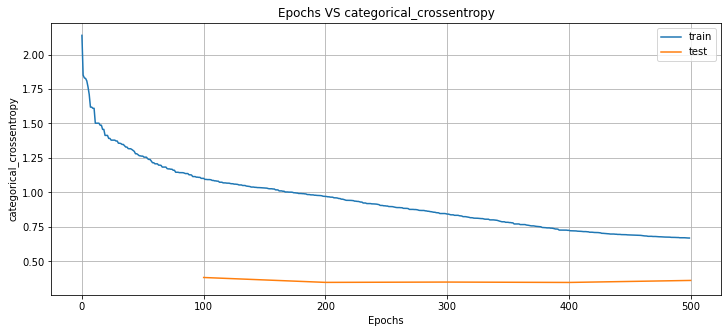

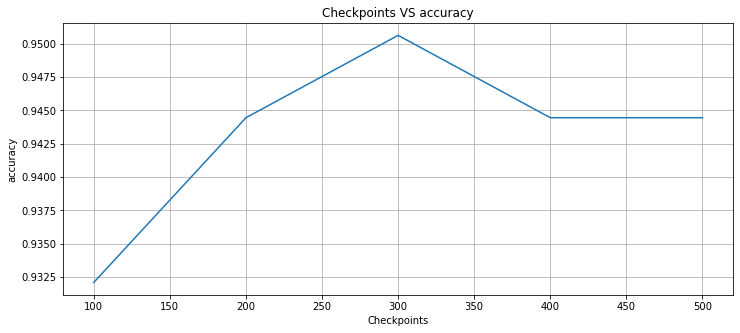

In [13]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9320987654320988, 'mean_square_error': 0.18687664664551026, 'categorical_crossentropy': 0.3830097692984122, 'precision': 0.8981481481481481, 'recall': 0.8981481481481481, 'f1': 0.8981481481481481, 'essential_metrics': {0: {'tp_hit': 79, 'fp_hit': 8, 'tn_hit': 20, 'fn_hit': 1}, 1: {'tp_hit': 10, 'fp_hit': 2, 'tn_hit': 91, 'fn_hit': 5}, 2: {'tp_hit': 8, 'fp_hit': 1, 'tn_hit': 94, 'fn_hit': 5}}, 'checkpoint': 100} 


{'accuracy': 0.9444444444444444, 'mean_square_error': 0.16563355283802375, 'categorical_crossentropy': 0.34754071412263093, 'precision': 0.9166666666666666, 'recall': 0.9166666666666666, 'f1': 0.9166666666666666, 'essential_metrics': {0: {'tp_hit': 79, 'fp_hit': 8, 'tn_hit': 20, 'fn_hit': 1}, 1: {'tp_hit': 10, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 5}, 2: {'tp_hit': 10, 'fp_hit': 1, 'tn_hit': 94, 'fn_hit': 3}}, 'checkpoint': 200} 


{'accuracy': 0.9506172839506173, 'mean_square_error': 0.16348720219410598, 'categorical_crossentropy': 0.3498353604917173, 'precisio

In [15]:
print(model)

Layer 1
Neuron 0: weights:
[-0.0430049   0.51799005  0.39381272 -0.8872093  -0.859958  ]
 bias: 0.15959876775741577

Neuron 1: weights:
[-0.57750034  0.5917295   0.37310454  0.10769554  0.11700574]
 bias: -0.6585838198661804

Neuron 2: weights:
[-0.33646607  0.61701417  0.11357912 -0.8549843  -1.1209135 ]
 bias: 0.3958762586116791

Neuron 3: weights:
[-0.68807155  1.6160133   0.8570598   0.5172443   0.2436131 ]
 bias: -0.930220365524292

$
Layer 2
Neuron 0: weights:
[ 0.9304943  -0.84130424  1.4324664  -1.4023149 ]
 bias: 0.5560938715934753

Neuron 1: weights:
[0.7116026  0.43623608 0.60119927 1.8808374 ]
 bias: -1.5084316730499268

Neuron 2: weights:
[-1.42957    -0.46679634 -1.4432184   0.08875999]
 bias: 1.0956093072891235

$

